# Section 3: Implementing policy gradients for a simple simulated environment

In the previous iterations of class, you have been introduced to gradient descent, where a learning agent takes a loss function and uses it to minimize it. In the case of reinforcement learning, there isn't a loss function, which means that you have to use policy gradients as a mean to approximate such gradients in order to optimize the learning agent.

In this exercise, you will be using policy gradients to approximate a polynomial function. Instead of using any derivatives to measure the change of loss, $L_\theta (x, y)$ with respect of parameters $\theta$, we would instead use reward signals $R(\tau)$ to approximate gradient descent, where $\tau$ denotes a sampled trajectory of a series of actions (collections of samples within a run).

We will assume you have a somewhat solid basis from deep learning, and we will go from here.

Special thank you to CS285 for helping to organize the content in this section! The mathematical derivation for policy gradient can be credited [here](https://rail.eecs.berkeley.edu/deeprlcourse/static/slides/lec-5.pdf)

## Install Dependencies

In [10]:
import numpy as np
import torch
import torch.nn as nn
import scipy
import matplotlib.pyplot as plt
import torch.nn.functional
import gym
from gym.wrappers.record_video import RecordVideo
from IPython import display
!pip install pyvirtualdisplay
from pyvirtualdisplay import Display
import torch.distributions as dist
# !pip install gym

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
!apt-get install -y libglu1-mesa-dev libgl1-mesa-dev libosmesa6-dev xvfb ffmpeg curl patchelf libglfw3 libglfw3-dev cmake zlib1g zlib1g-dev swig


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.1).
curl is already the newest version (7.81.0-1ubuntu1.13).
zlib1g is already the newest version (1:1.2.11.dfsg-2ubuntu9.2).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-2ubuntu9.2).
zlib1g-dev set to manually installed.
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  libegl-dev libegl1-mesa-dev libffi-dev libfontenc1 libgl-dev libgles-dev
  libgles1 libglu1-mesa libglvnd-core-dev libglvnd-dev libglx-dev
  libopengl-dev libosmesa6 libvulkan-dev libvulkan1 libwayland-bin
  libwayland-dev libxcb-randr0 libxfont2 libxkbfile1 libxrandr-dev
  mesa-vulkan-drivers swig4.0 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
Suggested packages:
  libglfw3-doc libwayland-doc swig-doc swig-examples swig4.0-examples
  swig4.0-doc
The followi

In [15]:
!pip install gym[box2d]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached pygame-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Using cached swig-4.1.1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.8 MB)
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2349103 sha256=3f3a8e61a70c626814bf5c06e9e1269501589b3617445d1f76ba0968eda72635
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.0
    Uninstalling pygame-2.5.0:
      Successfully uninstalled pygame-2.5.0


In [16]:
# This is used for video device to properly display pygame
!pip install pygame

import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

<Surface(640x480x32 SW)>

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"current device is {device}")

current device is cuda


In [18]:
env = gym.make("LunarLander-v2", render_mode = 'human', new_step_api=True)

## Setting Up the System

Before you start working on the code, here are some general traits of the environment that you can visualize:

In [ ]:
env.close()
print("The observation space: {}".format(env.observation_space))
print("The action space: {}".format(env.action_space))

The observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
The action space: Discrete(4)


The observation space comprises of 8 different states, each being the lower and upper bound of the state variables, and the action space is a discrete variable with 0, 1, 2, and 3, denoting the action that the agent chooses.

The following module defines the model that you'll be implementing policy gradients on. It includes a pre-defined MLP for said decision-making task, and you should fill out #TODOS to make sure the code runs properly.

In [ ]:
class PG_LR(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(8, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64,4)
    ).to(device)
    self.prob = nn.Softmax()
    self.logProb = []

  def forward(self, X):
    return self.prob(self.model(X))

  def reset(self):
    self.logProb = [] # a new iteration

Training and testing has been implemented here, fill in the blanks necessary for the program to work.

In [ ]:
torch.manual_seed(0x282A)
np.random.seed(0x282A)
if torch.cuda.is_available():
  torch.cuda.manual_seed(0x282A)
  torch.cuda.manual_seed_all(0x282A)
model = PG_LR()
iters = 500
lr = 0.005
gamma = 0.99 # DISCOUNT FACTOR
horizon = 100
optimizer = torch.optim.Adam(model.parameters(), lr)

totRewards = []


The REINFORCE Algorithm (Policy Gradients)
---

With technical aspects of running the simulation out of the way, let's introduce the REINFORCE algorithm, also known as policy gradients:

We can start by defining $J(\theta)$ as the expected total reward over trajectories collected by our policy θ: $J(\theta) = 𝔼_{\tau \sim p_\theta(\tau)}[∑_t r(s_t, a_t)]$, and our objective is:


#### <center> $θ*=argmax_\theta J(\theta)$ </center>

This value function can then tranform into the empirical average over the N samples we rolled out:

#### <center> $J(\theta) = \frac{1}{N} ∑_i ∑_t r(s_{i,t}, a_{i,t})$ </center>

Our Objectives
---

This will be important later, but let's just focus on the theoretical expected value for now. We want to take gradients of this objective function to reach for the highest possible value, thus we will take the gradient of the objective function with respect to θ and use gradient ascent. How can we do that?

Going back to the definition of expectation, we can in fact summarize $J(\theta)$ as an integral over all possible domains of the trajectory:

#### <center>$J(\theta) = 𝔼_{\tau \sim p_\theta(\tau)}[∑_t r(s_t, a_t)] = ∫_\tau l_\theta(\tau)r(\tau) d\tau$ </center>

Where $l_\theta(·)$ is the probability density function of such trajectory occurring under policy θ. Now we can take the gradient of this expression and get:

#### <center>$\nabla_\theta J(\theta) = ∫_\tau (\nabla_\theta l_\theta(\tau))r(\tau) d\tau$ </center>

Here, we are confronted with a tricky question: how can we derive $\nabla_\theta l_\theta(\tau)$? As far as we know, the calculation for the gradient of the objective function is intractable.

This is when we will reach for one of the convenient identities, where we can see that:

#### <center> $l_\theta(\tau)\nabla_\theta \log l_\theta(\tau)=l_\theta(\tau) \frac{\nabla_\theta l_\theta(\tau)}{l_\theta(\tau)} = \nabla_\theta l_\theta(\tau)$ </center>

Even though there's still a gradient term involved, we are now shifting the perspective, and thanks to this convenient identity, we now have:

#### <center>$\nabla_\theta J(\theta) = ∫_\tau l_\theta(\tau)(\nabla_\theta \log l_\theta(\tau))r(\tau) d\tau = 𝔼[\nabla_\theta \log l_\theta(\tau)r(\tau)]$ </center>

Which we can then calculate empirically.

How To Calculate the Gradient?
---
Okay, let's gather ourselves a little bit, now we have shown that the gradient of the objective function can be used as an expression of the log likelihood, what should we do about it? How should one derive the log likelihood anyway?

Let's recall the Markovian property in our RL environments: the current state only depends on the state one timestep before, thus we don't have to care about every single action we have taken, just the one that we have taken last time. Mathematically, we can express the likelihood of a specific trajectory with length $T$ happening as a cascade of transition likelihoods between each state and the subsequent state:

#### <center>$l_\theta(\tau) = l(s_1)\cdotp Π_{t=1}^T\pi_\theta(a_t|s_t)p(s_{t+1}|s_t,a_t)$</center>

Sidenote: we have to factor in $\pi_\theta(a_t|s_t)$, which is the probability of the agent taking the policy given the state, if our agent has a stochastic policy. Otherwise, we can set that to 1.

Taking the log of that, we have:

#### <center> $\log l_\theta(\tau) = \log l(s_1) + ∑_{t=1}^T \log \pi_\theta(a_t|s_t) + \log p(s_{t+1}|s_t, a_t)$ </center>

Once we take the gradient with respect to θ, we see that the first term and the third term cancels out, because they are not related to our parameters at all! Now all we have is this expression:

#### <center> $\nabla_\theta \log l_\theta(\tau) = ∑_{t=1}^T \nabla_\theta \log \pi_\theta(a_t|s_t)$ </center>

Now at this stage, we don't have to worry about the gradient at all, as $\pi(\cdotp)$ is a distribution derived by a neural network, and we can simply backpropagate through this. Which means that the gradient to our objective function became a succinct expression:

#### <center>$\nabla_\theta J(\theta) = 𝔼[(∑_{t=1}^T \nabla_\theta \log \pi_\theta(a_t|s_t)) (∑_{t=1}^T r(s_t, a_t))]$ </center>

And our empirical formula comes into play, giving us:

#### <center>$\nabla_\theta J(\theta) = \frac{1}{N} ∑_{i=1}^N (∑_{t=1}^T \nabla_\theta \log \pi_\theta(a_t|s_t)) (∑_{t=1}^T r(s_t, a_t))$ </center>

We can sometiems discard the constant at the front and reapply it when necessary, making it a simple double summation.

Putting Everything Together
---
Now we're done! We can assemble everything together and finish off the REINFORCE algorithm. Here's how it goes:

### REINFORCE
While $\theta$ is not converged:

  1. Sample trajectories $\{\tau_i\}_{i=1}^N$ that is derived from our policy $\pi_\theta(a_t|s_t)$

  2. Derive $\nabla_\theta J(\theta) = ∑_{i=1}^N (∑_{t=1}^T \nabla_\theta \log \pi_\theta(a_t|s_t)) (∑_{t=1}^T r(s_t, a_t))$

  3. $\theta ← \theta + \alpha \nabla_\theta J(\theta)$

What Does It Mean, Conceptually?
---

Generally, if we were to break down each term within the summation, we can see that if the reward is higher, we would like the log likelihood of that specific trajectory to be higher, which is then passed in as the substitute of the gradient of the objective function. This is what is known as 0th order optimization, where the objective function itself never had its own gradient evaluated while a surrogate objective does its job.

In [ ]:
# NOTE:

# Make sure you change the runtime to GPU, as policy gradients on CPU is very slow.

for i in range(iters):

  model.train()
  model.reset()
  rewards = []
  reward, steps = 0, 0
  currState = env.reset()
  currState = torch.from_numpy(currState).float()
  for j in range(horizon):
    # START Q1
    probability = ... # TODO
    distribution = ... # TODO, HINT: look up torch.distribution and find out the distribution that would be used for sampling categorical values
    action = ... # TODO
    model.logProb.append(...) # TODO: append the log probability


    action = int(action.item())
    # START Q2
    nextState, thisReward, done, _ = ... # TODO (How do we advance a step in the environment?)
    rewards.append(thisReward)
    currState = nextState
    if terminated or truncated:
      # If the agent screws up, terminate the process.
      break

  totReward = 0
  weightedReward = []
  for r in reversed(rewards):
    totReward = r + gamma * totReward
    weightedReward.insert(0, totReward)
  if not i % 5: # 5 here is used for iteration of evaluation
    totRewards.append(totReward)
    print(f"The reward collected at iteration {i} is {totReward}")
  optimizer.zero_grad()

  weightedReward = ... #TODO
  weightedReward = ... #TODO
  loss = ... #TOOD
  for logprob, reward in zip(model.logProb, weightedReward):
    loss -= ... #TODO

  loss.backward()
  optimizer.step()
  model.reset()

# SOLUTIONS:

In [ ]:
for i in range(iters):

  model.train()
  model.reset()
  rewards = []
  reward, steps = 0, 0
  currState = env.reset()
  currState = torch.from_numpy(currState).float()
  for j in range(horizon):
    # START Q1
    """
    probability = ... # TODO
    distribution = ... # TODO, HINT: look up torch.distribution and find out the distribution that would be used for sampling categorical values
    action = ... # TODO
    model.logProb.append(...) # TODO: append the log probability
    """
    ############
    # SOLUTION #
    ############
    probability = model(torch.tensor(currState).to(device))
    distribution = dist.categorical.Categorical(probability)
    action = distribution.sample()
    model.logProb.append(distribution.log_prob(action))
    ################
    # END SOLUTION #
    ################
    action = int(action.item())
    # START Q2
    """
    nextState, thisReward, done, _ = ... # TODO (How do we advance a step in the environment?)
    """
    ############
    # SOLUTION #
    ############
    nextState, thisReward, terminated, truncated, _ = env.step(action)
    ################
    # END SOLUTION #
    ################
    rewards.append(thisReward)
    currState = nextState
    if terminated or truncated:
      # If the agent screws up, terminate the process.
      break

  totReward = 0
  weightedReward = []
  for r in reversed(rewards):
    totReward = r + gamma * totReward
    weightedReward.insert(0, totReward)
  if not i % 5: # 5 here is used for iteration of evaluation
    totRewards.append(totReward)
    print(f"The reward collected at iteration {i} is {totReward}")
  optimizer.zero_grad()

  # Start Q3
  # How do we normalize weightedReward (subtracting a baseline)?
  # Now, for
  """
  weightedReward = ...
  weightedReward = ...
  loss = ...
  for logprob, reward in zip(model.logProb, weightedReward):
    loss -= ...
  """
  ############
  # SOLUTION #
  ############
  weightedReward = torch.tensor(weightedReward)
  weightedReward = (weightedReward - weightedReward.mean())/weightedReward.std()
  loss = 0
  for logprob, reward in zip(model.logProb, weightedReward):
    loss -= logprob * reward
  ################
  # END SOLUTION #
  ################
  loss.backward()
  optimizer.step()
  model.reset()

# VISUALIZATIONS

Here you will plot your total reward function from each test run (time deprecation included)

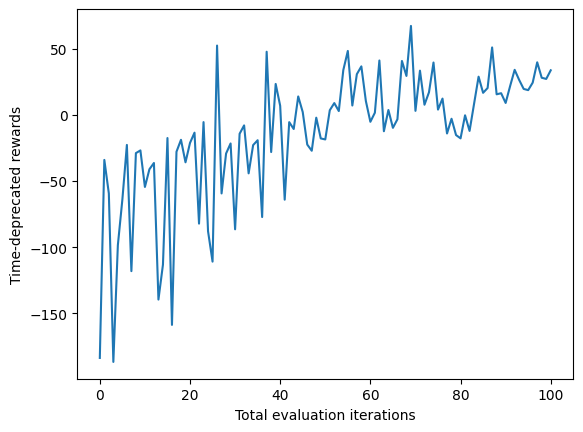

In [ ]:
plt.plot(np.arange(len(totRewards)), totRewards)
plt.xlabel("Total evaluation iterations")
plt.ylabel("Time-deprecated rewards")
plt.show()